In [11]:
import os 
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
) 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juane\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### I. For the 20N dataset compare two classifiers NB and LR to identify the 20 different newsgroups.
####     o Create your own processing pipeline for the task and justify it.
####     o Divide the dataset into training (60%), validation (10%) and test (30%).
####     o Train NB and LR using the following vector representations:
####     ▪ tf (counts) representation (sklearn: CountVectorizer).
####     ▪ tfidf representation (sklearn: TfidfVectorizer).

In [12]:
path_20N = 'datasets/20news-18828/20news-18828/'

In [13]:
def preprocess_text(text):
    text = text.lower()
    ### Remover correos electrónicos
    text = re.sub(r'[\w\d]+@[\w\d]+\.[\w\d]+\.?[\w\d]*\.?[\w\d]*\.?[\w\d]*\.?[\w\d]*',' ',text)
    #### Reemplazar números con la etiqueta NUM
    text = re.sub(r'\d+', 'NUM', text)
    # Remover con un expresión regular carateres especiales (no palabras) excepto signos de puntuación.
    text = re.sub(r'[^\w\s\.,:;\'\?]', ' ', str(text))
    # remover __ 
    text = re.sub(r'_+',' ',str(text))
    # minúsculas
    text = text.lower()
    # stemming
    text = " ".join([stemmer.stem(word) for word in text.split()])

    return text

In [14]:
def pipline_text(path20N):
    categoria = []
    texto = [] 

    for root, dirs, files in os.walk(path_20N):
        for file in files:
            categoria.append(root[root.rfind('/')+1:])
            with open(os.path.join(root,file),'r',encoding='latin-1') as file: 
                text = file.read()
                texto.append(preprocess_text(text))
    return texto,categoria
        

textos,categorias = pipline_text(path20N=path_20N)

In [15]:
vectorizer_tf = CountVectorizer(max_features=4000, stop_words=stopwords.words('english') )
texto_features_tf = vectorizer_tf.fit_transform(textos).toarray()
#Divide the dataset into training (60%), validation (10%) and test (30%).
x_temp_tf, x_test_tf, y_temp_tf, y_test_tf = train_test_split(texto_features_tf,categorias,test_size=0.3)
x_train_tf, x_val_tf, y_train_tf,y_val_tf = train_test_split(x_temp_tf,y_temp_tf,test_size=0.1)

In [16]:
vectorizer_tfidf = TfidfVectorizer(max_features=4000, stop_words=stopwords.words('english'))
texto_features_tfidf = vectorizer_tfidf.fit_transform(textos)
#Divide the dataset into training (60%), validation (10%) and test (30%).
x_temp_tfidf,x_test_tfidf,y_temp_tfidf,y_test_tfidf = train_test_split(texto_features_tfidf,categorias,test_size=0.3)
x_train_tfidf,x_val_tfidf,y_train_tfidf,y_val_tfidf = train_test_split(x_temp_tfidf,y_temp_tfidf)

### Train NB and LR

In [17]:
### Hacemos un entrenamiento tradicional para ver los resultados, haciendo un split de 70-30
### y tomar este modelo como linea base de comparación
nb_tf = MultinomialNB()
nb_tf.fit(x_temp_tf,y_temp_tf)  ## x_temp_tf,y_temp_tf el 70% de los datos
predictions_tf = nb_tf.predict(x_test_tf)
print(f" tf Naive Bayes accuracy score : {accuracy_score(y_test_tf,predictions_tf)}, params:{nb_tf.get_params()}")

nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_temp_tfidf,y_temp_tfidf) ## x_temp_tfidf,y_temp_tfidf el 70% de los datos
predictions_tfidf = nb_tfidf.predict(x_test_tfidf)
print(f" tfidf Naive Bayes accuracy_score: {accuracy_score(y_test_tfidf,predictions_tfidf)}, params: {nb_tfidf.get_params()}")

 tf Naive Bayes accuracy score : 0.7854487519915029, params:{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}
 tfidf Naive Bayes accuracy_score: 0.8371393166932201, params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}


In [18]:
### Hacemos un entrenamiento tradicional para ver los resultados, haciendo un split de 70-30
### y tomar este modelo como linea base de comparación
logistic_model_SGD_tf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.0001)
logistic_model_SGD_tf.fit(x_temp_tf,y_temp_tf)
predictions_SGD_tf = logistic_model_SGD_tf.predict(x_test_tf)
print(f'tf accuracy_score: {accuracy_score(y_test_tf,predictions_SGD_tf)}')

logistic_model_SGD_tfidf = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.0001)
logistic_model_SGD_tfidf.fit(x_temp_tfidf,y_temp_tfidf)
predictions_SGD_tfidf = logistic_model_SGD_tfidf.predict(x_test_tfidf)
print(f'tfidf accuracy_score: {accuracy_score(y_test_tfidf,predictions_SGD_tfidf)}')

tf accuracy_score: 0.7817312798725438
tfidf accuracy_score: 0.690564701717118


### Investigate cross-validation technique.
### o Explain what the strategy consists of and what it is used for.

### Compare the results of NB and LR using 10-fold cross validation


In [19]:
## para Naive Bayes buscamos el alpha más adecuado para suavizar con laplace, 
## usualmente alpha=1 y usamos el método de crosvalidation.
grid = {'alpha':[0.001,0.01,0.1,1,10]}  # buscamos sobre estos alphas para ver cuál es mejor
nb_tf_crossval = MultinomialNB()
grid_search_tf_crossval = GridSearchCV(nb_tf_crossval,grid, cv=10)   # 10 folders
grid_search_tf_crossval.fit(x_temp_tf,y_temp_tf)
print(f"mejores alpha: {grid_search_tf_crossval.best_params_}, mejor score: {grid_search_tf_crossval.best_score_}")
predictions_nb_tf_crossval = grid_search_tf_crossval.predict(x_test_tf)
print(f"tf cross validations accuracy_score: {accuracy_score(y_test_tf,predictions_nb_tf_crossval)}")


mejores alpha: {'alpha': 0.1}, mejor score: 0.7973283304701101
tf cross validations accuracy_score: 0.7937688086386971


#

In [20]:
## para Naive Bayes buscamos el alpha más adecuado para suavizar con laplace, 
## usualmente alpha=1 y usamos el método de crosvalidation.
grid = {'alpha':[0.001,0.01,0.1,1,10]}  # buscamos sobre estos alphas para ver cuál es mejor
nb_tfid_crossval = MultinomialNB()
grid_search_tfid_crossval = GridSearchCV(nb_tfid_crossval,grid, cv=10,scoring='accuracy')   # 10 folders
grid_search_tfid_crossval.fit(x_temp_tfidf,y_temp_tfidf)
print(f"mejores alpha: {grid_search_tfid_crossval.best_params_}, mejor score: {grid_search_tfid_crossval.best_score_}")
predictions_nb_tfid_crossval = grid_search_tfid_crossval.predict(x_test_tfidf)
print(f"tfid cross validations accuracy_score: {accuracy_score(y_test_tfidf,predictions_nb_tfid_crossval)}")



mejores alpha: {'alpha': 0.1}, mejor score: 0.8520373244475478
tfid cross validations accuracy_score: 0.8495308904230837


In [21]:
param_grid_SGVclassifier = {
    'learning_rate': ['constant'],
    'eta0': [0.001, 0.01, 0.1, 1],  
}

sgvclas_tf_crv = SGDClassifier(loss='log_loss',max_iter=1000,tol=0.001)
grid_search_sgvclas_tf_crv = GridSearchCV(sgvclas_tf_crv,param_grid_SGVclassifier,cv=10,scoring='accuracy')
grid_search_sgvclas_tf_crv.fit(x_temp_tf,y_temp_tf) # 70% data
print(f'mejores params: {grid_search_sgvclas_tf_crv.best_params_}, mejor score: {grid_search_sgvclas_tf_crv.best_score_}')
predictions_sgvclass_tf_crv = grid_search_sgvclas_tf_crv.predict(x_test_tf)
print(f'tf score sgv crossv: {accuracy_score(y_test_tf,predictions_sgvclass_tf_crv)}')

mejores params: {'eta0': 0.001, 'learning_rate': 'constant'}, mejor score: 0.7882248361856106
tf score sgv crossv: 0.7960701009028146


In [22]:
param_grid_SGVclassifier = {
    'learning_rate': ['constant'],
    'eta0': [0.001, 0.01, 0.1, 1],  
}

sgvclas_tfidf_crv = SGDClassifier(loss='log_loss',max_iter=1000,tol=0.001)
grid_search_sgvclas_tfidf_crv = GridSearchCV(sgvclas_tfidf_crv,param_grid_SGVclassifier,cv=10,scoring='accuracy')
grid_search_sgvclas_tfidf_crv.fit(x_temp_tfidf,y_temp_tfidf) # 70% data
print(f'mejores params: {grid_search_sgvclas_tfidf_crv.best_params_}, mejor score: {grid_search_sgvclas_tfidf_crv.best_score_}')
predictions_sgvclass_tfidf_crv = grid_search_sgvclas_tfidf_crv.predict(x_test_tfidf)
print(f'tfidf score sgv crossv: {accuracy_score(y_test_tfidf,predictions_sgvclass_tfidf_crv)}')


mejores params: {'eta0': 0.1, 'learning_rate': 'constant'}, mejor score: 0.842021228178725
tfidf score sgv crossv: 0.844397238449283


### o Compare the results of NB and LR using 10-fold cross validation

tf Naive-Bayes cross validation accuracy_score: 0.7976633032395114
mejores alpha: {'alpha': 0.1}

tfid Naive-Bayes cross validation accuracy_score: 0.8534253850238981
mejores alpha: {'alpha': 0.1}

tf sgv-classifier crossv accuracy_score: 0.8006726854310497
mejores params: {'eta0': 0.001, 'learning_rate': 'constant'}

tfidf sgv-classifier crossv  accuracy_score: 0.8410338112940343
mejores params: {'eta0': 0.1, 'learning_rate': 'constant'}


### III. Evaluate models using the test set:
### o Report precision, recall, and F1 with the micro and micro average results.
### o What is the best model?

In [23]:
# presicion macro
precision_macro_nb_tf = precision_score(y_test_tf,predictions_nb_tf_crossval,average='macro')
precision_macro_nb_tfidf = precision_score(y_test_tfidf,predictions_nb_tfid_crossval,average='macro')
precision_macro_svgclass_tf  = precision_score(y_test_tf,predictions_sgvclass_tf_crv,average='macro')
presicion_macro_svgclass_tfidf = precision_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='macro')

# recall macro
recall_macro_nb_tf = recall_score(y_test_tf,predictions_nb_tf_crossval,average='macro')
recall_macro_nb_tfidf = recall_score(y_test_tfidf,predictions_nb_tfid_crossval,average='macro')
recall_macro_svgclass_tf = recall_score(y_test_tf,predictions_sgvclass_tf_crv,average='macro')
recall_macro_svgclass_tfidf = recall_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='macro')

# f1 score macro
f1score_macro_nb_tf = f1_score(y_test_tf,predictions_nb_tf_crossval,average='macro')
f1score_macro_nb_tfidf = f1_score(y_test_tfidf,predictions_nb_tfid_crossval,average='macro')
f1score_macro_svgclass_tf = f1_score(y_test_tf,predictions_sgvclass_tf_crv,average='macro')
f1score_macro_svgclass_tfidf = f1_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='macro')

# presicion micro
precision_micro_nb_tf = precision_score(y_test_tf,predictions_nb_tf_crossval,average='micro')
precision_micro_nb_tfidf = precision_score(y_test_tfidf,predictions_nb_tfid_crossval,average='micro')
precision_micro_svgclass_tf  = precision_score(y_test_tf,predictions_sgvclass_tf_crv,average='micro')
presicion_micro_svgclass_tfidf = precision_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='micro')

# recall micro
recall_micro_nb_tf = recall_score(y_test_tf,predictions_nb_tf_crossval,average='micro')
recall_micro_nb_tfidf = recall_score(y_test_tfidf,predictions_nb_tfid_crossval,average='micro')
recall_micro_svgclass_tf = recall_score(y_test_tf,predictions_sgvclass_tf_crv,average='micro')
recall_micro_svgclass_tfidf = recall_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='micro')

# f1 score macro
f1score_micro_nb_tf = f1_score(y_test_tf,predictions_nb_tf_crossval,average='micro')
f1score_micro_nb_tfidf = f1_score(y_test_tfidf,predictions_nb_tfid_crossval,average='micro')
f1score_micro_svgclass_tf = f1_score(y_test_tf,predictions_sgvclass_tf_crv,average='micro')
f1score_micro_svgclass_tfidf = f1_score(y_test_tfidf,predictions_sgvclass_tfidf_crv,average='micro')



In [24]:
results = {'precision_macro_nb_tf':precision_macro_nb_tf,
'precision_macro_nb_tfidf':precision_macro_nb_tfidf,
'precision_macro_svgclass_tf':precision_macro_svgclass_tf,
'presicion_macro_svgclass_tfidf':presicion_macro_svgclass_tfidf,
'recall_macro_nb_tf':recall_macro_nb_tf,
'recall_macro_nb_tfidf':recall_macro_nb_tfidf,
'recall_macro_svgclass_tf':recall_macro_svgclass_tf,
'recall_macro_svgclass_tfidf':recall_macro_svgclass_tfidf,
'f1score_macro_nb_tf':f1score_macro_nb_tf,
'f1score_macro_nb_tfidf':f1score_macro_nb_tfidf,
'f1score_macro_svgclass_tf':f1score_macro_svgclass_tf,
'f1score_macro_svgclass_tfidf':f1score_macro_svgclass_tfidf,
'precision_micro_nb_tf':precision_micro_nb_tf,
'precision_micro_nb_tfidf':precision_micro_nb_tfidf,
'precision_micro_svgclass_tf':precision_micro_svgclass_tf,
'presicion_micro_svgclass_tfidf':presicion_micro_svgclass_tfidf,
'recall_micro_nb_tf':recall_micro_nb_tf,
'recall_micro_nb_tfidf':recall_micro_nb_tfidf,
'recall_micro_svgclass_tf':recall_micro_svgclass_tf,
'recall_micro_svgclass_tfidf':recall_micro_svgclass_tfidf,
'f1score_micro_nb_tf':f1score_micro_nb_tf,
'f1score_micro_nb_tfidf':f1score_micro_nb_tfidf,
'f1score_micro_svgclass_tf':f1score_micro_svgclass_tf,
'f1score_micro_svgclass_tfidf':f1score_micro_svgclass_tfidf,
}

In [25]:
for key,value in results.items(): 
    print(f'{key}: {value}')

precision_macro_nb_tf: 0.8031757648356919
precision_macro_nb_tfidf: 0.8514601617359647
precision_macro_svgclass_tf: 0.7999163644334659
presicion_macro_svgclass_tfidf: 0.8440491785757906
recall_macro_nb_tf: 0.7964037977409798
recall_macro_nb_tfidf: 0.8423458633354507
recall_macro_svgclass_tf: 0.7950101322538454
recall_macro_svgclass_tfidf: 0.8362354667600016
f1score_macro_nb_tf: 0.7792011482282863
f1score_macro_nb_tfidf: 0.8434506251743006
f1score_macro_svgclass_tf: 0.7919228636486852
f1score_macro_svgclass_tfidf: 0.836831256170661
precision_micro_nb_tf: 0.7937688086386971
precision_micro_nb_tfidf: 0.8495308904230837
precision_micro_svgclass_tf: 0.7960701009028146
presicion_micro_svgclass_tfidf: 0.844397238449283
recall_micro_nb_tf: 0.7937688086386971
recall_micro_nb_tfidf: 0.8495308904230837
recall_micro_svgclass_tf: 0.7960701009028146
recall_micro_svgclass_tfidf: 0.844397238449283
f1score_micro_nb_tf: 0.7937688086386971
f1score_micro_nb_tfidf: 0.8495308904230837
f1score_micro_svgclass

Dado los resultados expresados en la siguiente tabla, el modelo Naive-Bayes con representación vectorial tfidf se elige como mejor modelo: 
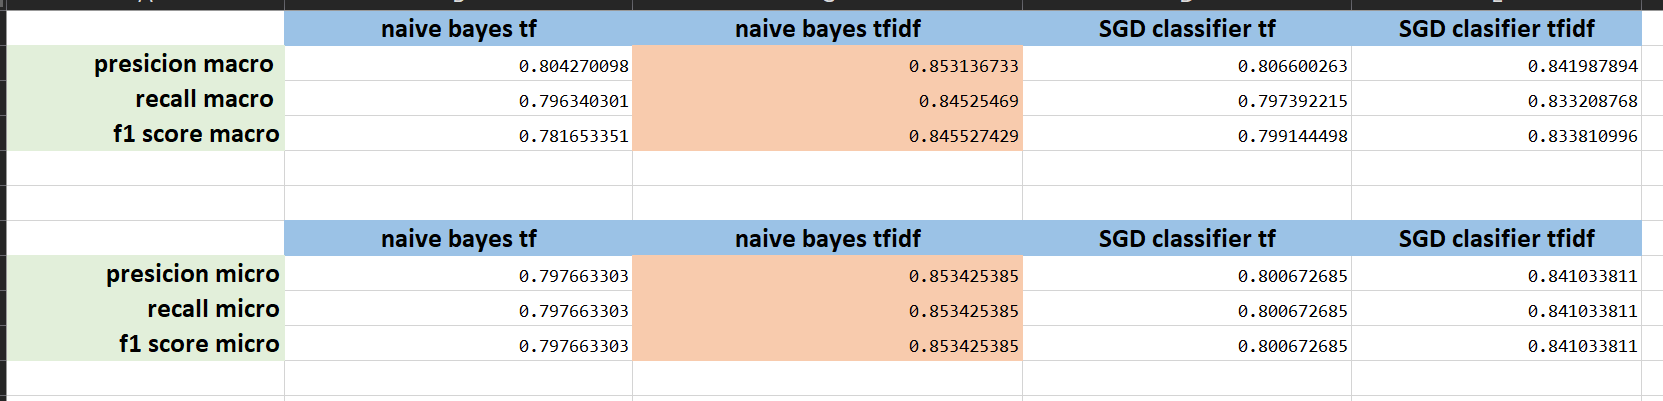

In [26]:
# hacemos una función para entrenamiento por épocas para 
# el SGDClassifier evitando sobreajuste

def SGD_epochs(xtrain,ytrain,xval,yval,num_epochs,tolerance=0.1,stop=5):
    best_accuracy = 0
    num_noimprovements = 0
    best_model = None
    clases = np.unique(ytrain)
    model = SGDClassifier(loss='log_loss',learning_rate='constant',eta0=0.0001) 
    for i in range(num_epochs):
        # print(f'época: {i}') 
        model.fit(xtrain,ytrain)  # entrenar con pequeños lotes de datos 
        predictions = model.predict(xval)

        accuracy = accuracy_score(yval,predictions)

        if accuracy > best_accuracy*(1+tolerance):
            best_accuracy = accuracy
            best_model = model 
            num_noimprovements = 0 
        else: 
            num_noimprovements += 1

        print(f'best accuracy: {best_accuracy},epoch: {i}')
        if num_noimprovements>(stop-2):
            print(f'existe posible sobreajuste, época: {i}')
            return  best_model
        
    return best_model

model_tf = SGD_epochs(x_train_tf,y_train_tf,x_val_tf,y_val_tf,100)
predictions_tf2 = model_tf.predict(x_test_tf)
print(f'tf accuracy: {accuracy_score(y_test_tf,predictions_tf2)}')
model_tf.get_params()

best accuracy: 0.7776934749620638,epoch: 0
best accuracy: 0.7776934749620638,epoch: 1
best accuracy: 0.7776934749620638,epoch: 2
best accuracy: 0.7776934749620638,epoch: 3
best accuracy: 0.7776934749620638,epoch: 4
existe posible sobreajuste, época: 4
tf accuracy: 0.7847406620640821


{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0001,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'constant',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [27]:
model_tf.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0001,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'constant',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}